<a href="https://colab.research.google.com/github/Arindaym1/Energy-Level-Production-Time-Series-Data-/blob/main/Energy_Prediction_(Time_Series_Data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***EDA***

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU

import datetime


In [ ]:
# Load your dataset (replace with actual file path)
data = pd.read_csv('/content/drive/MyDrive/INTERNSHIP/intermittent-renewables-production-france.csv')

# Display first few rows
data.head()


,Date and Hour,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName
0,2020-07-22 20:00:00+02:00,2020-07-22,20:00:00,21:00:00,Solar,244.0,204,Wednesday,July
1,2020-07-23 07:00:00+02:00,2020-07-23,07:00:00,08:00:00,Solar,223.0,205,Thursday,July
2,2020-07-23 16:00:00+02:00,2020-07-23,16:00:00,17:00:00,Solar,2517.0,205,Thursday,July
3,2020-07-23 19:00:00+02:00,2020-07-23,19:00:00,20:00:00,Solar,658.0,205,Thursday,July
4,2020-07-23 23:00:00+02:00,2020-07-23,23:00:00,24:00:00,Solar,0.0,205,Thursday,July


In [ ]:
missing_values = data.isnull().sum()
print("Missing values for each column:")
print(missing_values)


Missing values for each column:
Date and Hour    0
Date             0
StartHour        0
EndHour          0
Source           0
Production       2
dayOfYear        0
dayName          0
monthName        0
dtype: int64


In [ ]:
# Count the number of entries for each month
month_counts = data.groupby('monthName').size()
print("Number of entries for each month:")
print(month_counts)


Number of entries for each month:
monthName
January      5952
February     5424
March        4458
April        5760
May          5952
June         5760
July         4464
August       4464
September    4320
October      4466
November     4320
December     4464
dtype: int64


<ipython-input-61-d3fe214ad6e4>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  month_counts = data.groupby('monthName').size()


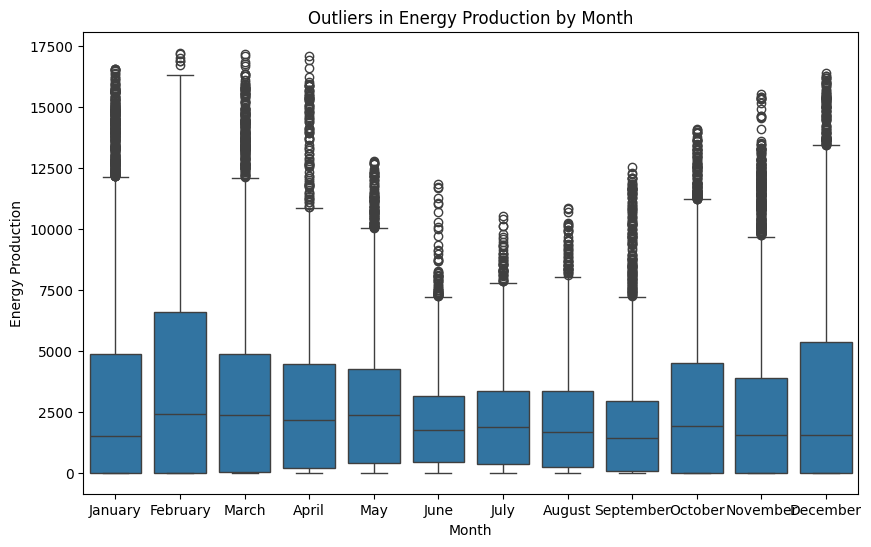

In [ ]:
# Boxplot to visualize outliers in the 'Production' column
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='monthName', y='Production')
plt.title('Outliers in Energy Production by Month')
plt.xlabel('Month')
plt.ylabel('Energy Production')
plt.show()


In [ ]:
# Group by 'month' and calculate IQR, upper bound, and lower bound
outlier_counts = {}

for month, group in data.groupby('monthName'):
    Q1 = group['Production'].quantile(0.25)  # 1st quartile (25%)
    Q3 = group['Production'].quantile(0.75)  # 3rd quartile (75%)
    IQR = Q3 - Q1  # Interquartile range

    # Calculate bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outliers = group[(group['Production'] < lower_bound) | (group['Production'] > upper_bound)]
    outlier_counts[month] = outliers.shape[0]

# Print the count of outliers for each month
for month, count in outlier_counts.items():
    print(f'Month: {month}, Outlier Count: {count}')


Month: January, Outlier Count: 324
Month: February, Outlier Count: 6
Month: March, Outlier Count: 236
Month: April, Outlier Count: 97
Month: May, Outlier Count: 104
Month: June, Outlier Count: 60
Month: July, Outlier Count: 47
Month: August, Outlier Count: 49
Month: September, Outlier Count: 152
Month: October, Outlier Count: 129
Month: November, Outlier Count: 294
Month: December, Outlier Count: 113


<ipython-input-65-58c75377b545>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for month, group in data.groupby('monthName'):


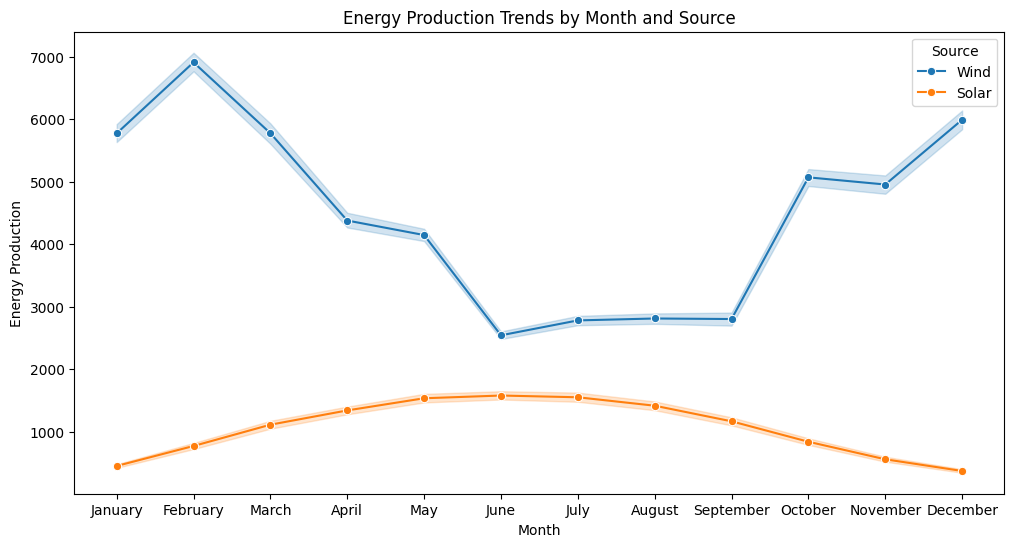

In [ ]:
# Lineplot to visualize energy production trends for each month
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='monthName', y='Production', hue='Source', marker='o')
plt.title('Energy Production Trends by Month and Source')
plt.xlabel('Month')
plt.ylabel('Energy Production')
plt.show()


In [ ]:
# Step 1: Count the total number of entries for each month
month_counts = data.groupby('monthName').size()

# Step 2: Calculate the number of outliers for each month (already done in your code)
outlier_counts = {}

for month, group in data.groupby('monthName'):
    Q1 = group['Production'].quantile(0.25)  # 1st quartile (25%)
    Q3 = group['Production'].quantile(0.75)  # 3rd quartile (75%)
    IQR = Q3 - Q1  # Interquartile range

    # Calculate bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outliers = group[(group['Production'] < lower_bound) | (group['Production'] > upper_bound)]
    outlier_counts[month] = outliers.shape[0]

# Step 3: Calculate the percentage of outliers for each month
print("Percentage of outliers for each month:")
for month in month_counts.index:
    total_entries = month_counts[month]
    outliers = outlier_counts.get(month, 0)  # Get the outlier count, default to 0 if no outliers
    percentage_outliers = (outliers / total_entries) * 100
    print(f"Month: {month}, Outliers: {outliers}, Total Entries: {total_entries}, Percentage Outliers: {percentage_outliers:.2f}%")


Percentage of outliers for each month:
Month: January, Outliers: 324, Total Entries: 5952, Percentage Outliers: 5.44%
Month: February, Outliers: 6, Total Entries: 5424, Percentage Outliers: 0.11%
Month: March, Outliers: 236, Total Entries: 4460, Percentage Outliers: 5.29%
Month: April, Outliers: 97, Total Entries: 5760, Percentage Outliers: 1.68%
Month: May, Outliers: 104, Total Entries: 5952, Percentage Outliers: 1.75%
Month: June, Outliers: 60, Total Entries: 5760, Percentage Outliers: 1.04%
Month: July, Outliers: 47, Total Entries: 4464, Percentage Outliers: 1.05%
Month: August, Outliers: 49, Total Entries: 4464, Percentage Outliers: 1.10%
Month: September, Outliers: 152, Total Entries: 4320, Percentage Outliers: 3.52%
Month: October, Outliers: 129, Total Entries: 4466, Percentage Outliers: 2.89%
Month: November, Outliers: 294, Total Entries: 4320, Percentage Outliers: 6.81%
Month: December, Outliers: 113, Total Entries: 4464, Percentage Outliers: 2.53%


<ipython-input-35-557d70946d17>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  month_counts = data.groupby('monthName').size()
<ipython-input-35-557d70946d17>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for month, group in data.groupby('monthName'):


<ipython-input-75-16a535d5b81a>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  september_data['StartHourRange'] = september_data['StartHour'].apply(categorize_start_hour)
<ipython-input-75-16a535d5b81a>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  september_data['StartHourRange'] = pd.Categorical(september_data['StartHourRange'],


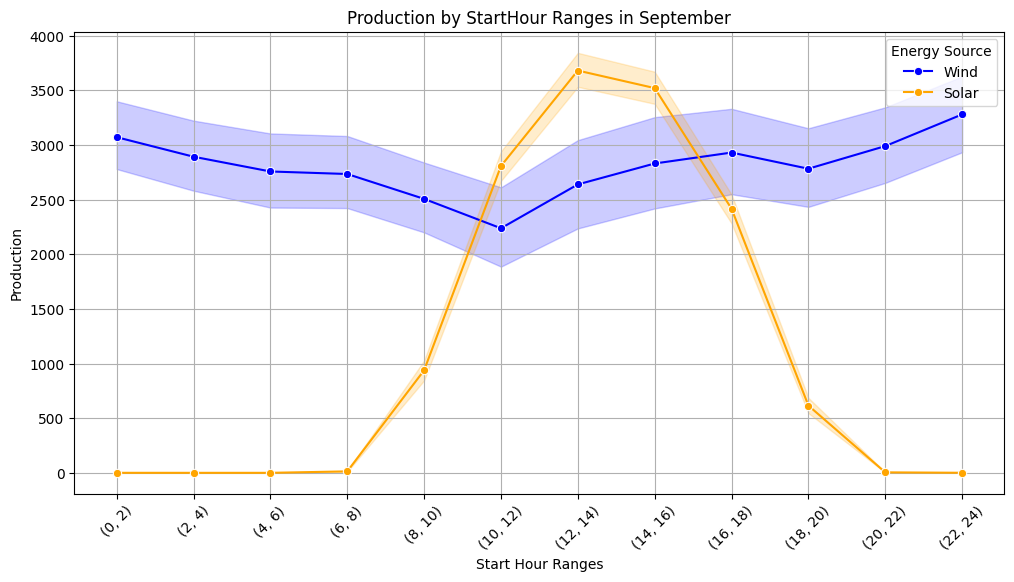

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to categorize StartHour into specified ranges
def categorize_start_hour(hour):
    if 0 <= hour < 2:
        return '(0, 2)'
    elif 2 <= hour < 4:
        return '(2, 4)'
    elif 4 <= hour < 6:
        return '(4, 6)'
    elif 6 <= hour < 8:
        return '(6, 8)'
    elif 8 <= hour < 10:
        return '(8, 10)'
    elif 10 <= hour < 12:
        return '(10, 12)'
    elif 12 <= hour < 14:
        return '(12, 14)'
    elif 14 <= hour < 16:
        return '(14, 16)'
    elif 16 <= hour < 18:
        return '(16, 18)'
    elif 18 <= hour < 20:
        return '(18, 20)'
    elif 20 <= hour < 22:
        return '(20, 22)'
    elif 22 <= hour < 24:
        return '(22, 24)'
    else:
        return 'Other'

# Apply the categorization function to create a new column for hour ranges
september_data['StartHourRange'] = september_data['StartHour'].apply(categorize_start_hour)

# Set the color palette for the sources
palette = {'Solar': 'orange', 'Wind': 'blue'}

# Ensure 'StartHourRange' is treated as a categorical type for proper ordering
september_data['StartHourRange'] = pd.Categorical(september_data['StartHourRange'],
                                                   categories=['(0, 2)', '(2, 4)', '(4, 6)', '(6, 8)',
                                                               '(8, 10)', '(10, 12)', '(12, 14)', '(14, 16)',
                                                               '(16, 18)', '(18, 20)', '(20, 22)', '(22, 24)'],
                                                   ordered=True)

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=september_data, x='StartHourRange', y='Production', hue='Source', palette=palette, marker='o')

# Adding titles and labels
plt.title('Production by StartHour Ranges in September')
plt.xlabel('Start Hour Ranges')
plt.ylabel('Production')
plt.legend(title='Energy Source')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.grid(True)

# Show the plot
plt.show()


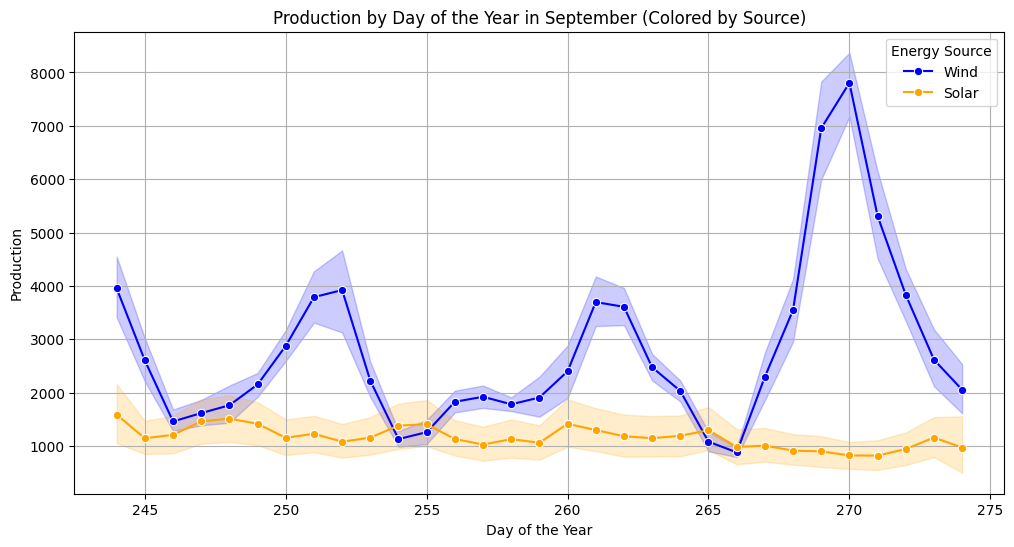

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the color palette for the sources
palette = {'Solar': 'orange', 'Wind': 'blue'}

# Create the line plot for dayOfYear vs Production, differentiated by 'Source'
plt.figure(figsize=(12, 6))
sns.lineplot(data=september_data, x='dayOfYear', y='Production', hue='Source', palette=palette, marker='o')

# Adding titles and labels
plt.title('Production by Day of the Year in September (Colored by Source)')
plt.xlabel('Day of the Year')
plt.ylabel('Production')
plt.legend(title='Energy Source')
plt.grid(True)

# Show the plot
plt.show()



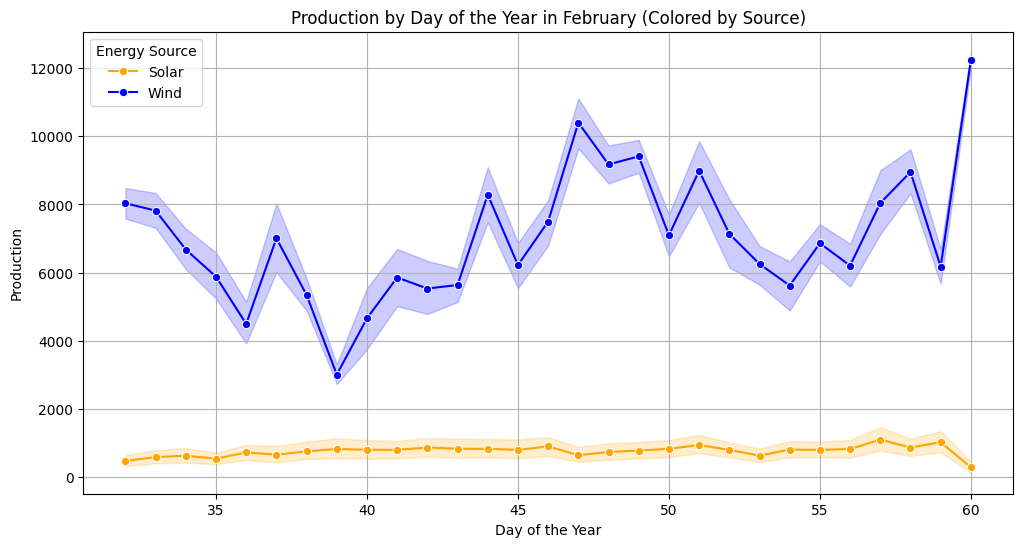

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the color palette for the sources
palette = {'Solar': 'orange', 'Wind': 'blue'}

# Create the line plot for dayOfYear vs Production, differentiated by 'Source'
plt.figure(figsize=(12, 6))
sns.lineplot(data=february_data, x='dayOfYear', y='Production', hue='Source', palette=palette, marker='o')

# Adding titles and labels
plt.title('Production by Day of the Year in February (Colored by Source)')
plt.xlabel('Day of the Year')
plt.ylabel('Production')
plt.legend(title='Energy Source')
plt.grid(True)

# Show the plot
plt.show()



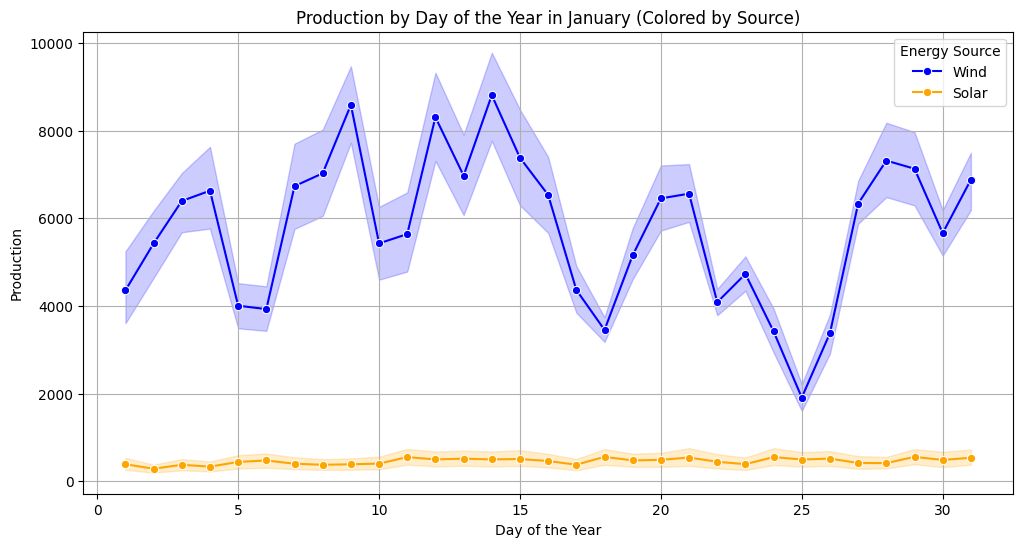

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the color palette for the sources
palette = {'Solar': 'orange', 'Wind': 'blue'}

# Create the line plot for dayOfYear vs Production, differentiated by 'Source'
plt.figure(figsize=(12, 6))
sns.lineplot(data=january_data, x='dayOfYear', y='Production', hue='Source', palette=palette, marker='o')

# Adding titles and labels
plt.title('Production by Day of the Year in January (Colored by Source)')
plt.xlabel('Day of the Year')
plt.ylabel('Production')
plt.legend(title='Energy Source')
plt.grid(True)

# Show the plot
plt.show()


<ipython-input-97-45a1c5da2048>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  september_data['weekOfYear'] = september_data['dayOfYear'].apply(lambda x: (x - 1) // 7 + 1)


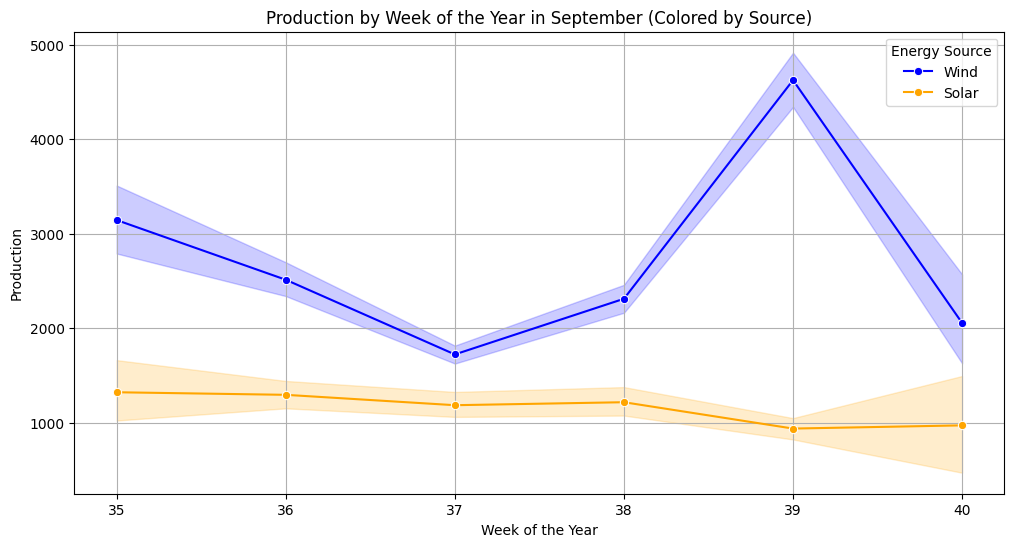

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new column for week of the year from 'dayOfYear'
september_data['weekOfYear'] = september_data['dayOfYear'].apply(lambda x: (x - 1) // 7 + 1)

# Set the color palette for the sources
palette = {'Solar': 'orange', 'Wind': 'blue'}

# Create the line plot for weekOfYear vs Production, differentiated by 'Source'
plt.figure(figsize=(12, 6))
sns.lineplot(data=september_data, x='weekOfYear', y='Production', hue='Source', palette=palette, marker='o')

# Adding titles and labels
plt.title('Production by Week of the Year in September (Colored by Source)')
plt.xlabel('Week of the Year')
plt.ylabel('Production')
plt.legend(title='Energy Source')
plt.grid(True)

# Show the plot
plt.show()


<ipython-input-99-faf60ffbed46>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  february_data['date'] = pd.to_datetime(february_data['dayOfYear'].astype(str) + '-2024', format='%j-%Y')
<ipython-input-99-faf60ffbed46>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  february_data['weekOfYear'] = february_data['date'].dt.isocalendar().week


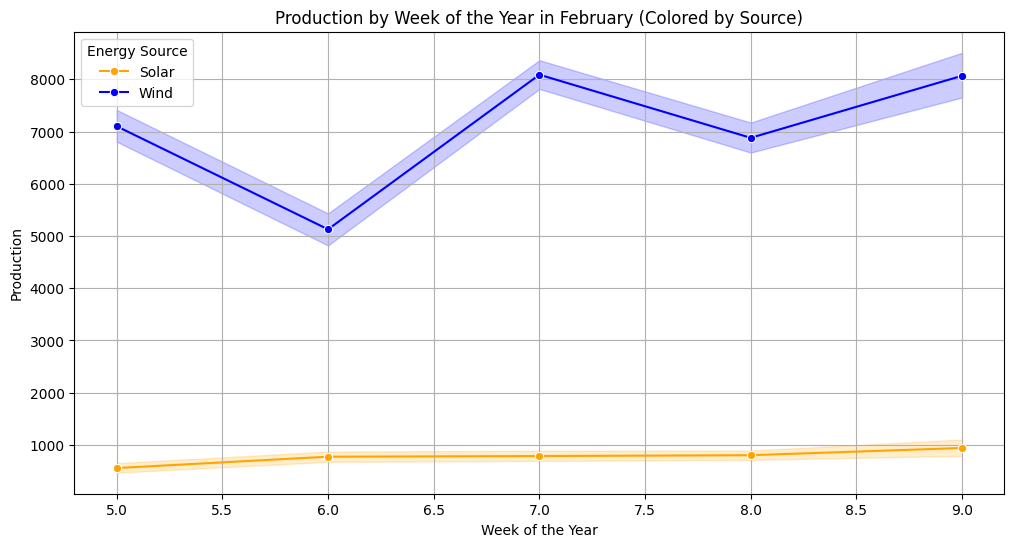

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure to convert the 'dayOfYear' to actual datetime for February
# Assuming february_data has a 'dayOfYear' column ranging from 1 to 28 (or 29 for leap years)
february_data['date'] = pd.to_datetime(february_data['dayOfYear'].astype(str) + '-2024', format='%j-%Y')

# Create a new column for week of the year using the datetime object
february_data['weekOfYear'] = february_data['date'].dt.isocalendar().week

# Set the color palette for the sources
palette = {'Solar': 'orange', 'Wind': 'blue'}

# Create the line plot for weekOfYear vs Production, differentiated by 'Source'
plt.figure(figsize=(12, 6))
sns.lineplot(data=february_data, x='weekOfYear', y='Production', hue='Source', palette=palette, marker='o')

# Adding titles and labels
plt.title('Production by Week of the Year in February (Colored by Source)')
plt.xlabel('Week of the Year')
plt.ylabel('Production')
plt.legend(title='Energy Source')
plt.grid(True)

# Show the plot
plt.show()


# BASELINE RANDOM FOREST ***REGRESSOR***

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/INTERNSHIP/intermittent-renewables-production-france.csv')

In [ ]:
data=data.dropna(subset=['Production'])
# Assuming 'StartHour' is a string in the format 'HH:MM:SS'
# Extract the hour part and convert it to an integer
data['StartHour'] = pd.to_datetime(data['StartHour'], format='%H:%M:%S').dt.hour

In [ ]:
# Ensure that the 'monthName' column is treated as a categorical variable with the correct order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Convert 'monthName' to categorical type with the specified order
data['monthName'] = pd.Categorical(data['monthName'], categories=month_order, ordered=True)

# Sort the dataset by 'monthName'
data= data.sort_values(by='monthName')

# Display the first few rows of the sorted dataset
print(data.head())

                   Date and Hour        Date  StartHour   EndHour Source  \
34800  2022-01-01 14:00:00+01:00  2022-01-01         14  15:00:00   Wind   
32468  2022-01-10 17:00:00+01:00  2022-01-10         17  18:00:00   Wind   
32467  2022-01-10 06:00:00+01:00  2022-01-10          6  07:00:00   Wind   
32466  2022-01-10 05:00:00+01:00  2022-01-10          5  06:00:00   Wind   
32465  2022-01-10 03:00:00+01:00  2022-01-10          3  04:00:00   Wind   

       Production  dayOfYear   dayName monthName  
34800      2811.0          1  Saturday   January  
32468      1834.0         10    Monday   January  
32467      1006.0         10    Monday   January  
32466       964.0         10    Monday   January  
32465       832.0         10    Monday   January  


In [ ]:
# Select relevant features based on EDA insights
features = ['monthName', 'StartHour', 'dayOfYear', 'Source', 'Production']
data = data[features]
data.head()

,monthName,StartHour,dayOfYear,Source,Production
34800,January,14,1,Wind,2811.0
32468,January,17,10,Wind,1834.0
32467,January,6,10,Wind,1006.0
32466,January,5,10,Wind,964.0
32465,January,3,10,Wind,832.0


In [ ]:
# Handle categorical features with Label Encoding
label_encoders = {}
for column in ['monthName', 'Source']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le
data.head()

,monthName,StartHour,dayOfYear,Source,Production
34800,4,14,1,1,2811.0
32468,4,17,10,1,1834.0
32467,4,6,10,1,1006.0
32466,4,5,10,1,964.0
32465,4,3,10,1,832.0


In [ ]:
#data = pd.get_dummies(data, columns=['monthName', 'Source'], drop_first=False)

# # Standardize the Production column
# #scaler = StandardScaler()
# from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler


# # Assuming 'data' is your DataFrame
scaler = MinMaxScaler()
data['Production'] = scaler.fit_transform(data[['Production']])
data['dayOfYear'] = scaler.fit_transform(data[['dayOfYear']])
data['StartHour'] = scaler.fit_transform(data[['StartHour']])

# data['Production'] = scaler.fit_transform(data[['Production']])
data.head()


,monthName,StartHour,dayOfYear,Source,Production
34800,4,0.608696,0.000000,1,0.163240
32468,4,0.739130,0.024658,1,0.106504
32467,4,0.260870,0.024658,1,0.058420
32466,4,0.217391,0.024658,1,0.055981
32465,4,0.130435,0.024658,1,0.048316


In [ ]:
# Separate features and target variable
X = data.drop('Production', axis=1)
y = data['Production']

In [ ]:
# Ensure lengths match and reset indexes to prevent misalignment
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [ ]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Baseline Model: Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate the Random Forest model
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Performance:")
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("R2 Score:", r2_score(y_test, y_pred_rf))

Random Forest Performance:
MSE: 0.023221798196760794
MAE: 0.09026699627345808
R2 Score: 0.33360752591135356


# ***HYPERPARAMETER TUNED RANDOM FOREST REGRESSOR***

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 400, 800],  # Number of trees in the forest
    'max_depth': [80, 160, 40, None],      # Maximum depth of each tree
    'min_samples_split': [4, 5, 20],      # Minimum number of samples required to split a node
    'min_samples_leaf': [3, 6, 12],        # Minimum number of samples required at a leaf node
    'bootstrap': [True, False]            # Whether bootstrap samples are used when building trees
}

In [ ]:
# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=13)

In [ ]:
# RandomizedSearchCV (performs a randomized search, useful when the parameter space is large)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=2, cv=2, random_state=42, n_jobs=-1, verbose=2)


In [ ]:
random_search.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(random_state=13),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [80, 160, 240, None],
                                        'min_samples_leaf': [3, 6, 12],
                                        'min_samples_split': [4, 5, 20],
                                        'n_estimators': [100, 200, 400, 800]},
                   random_state=42, verbose=2)

In [ ]:
# Get the best parameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# 3. Train a Random Forest model using the best hyperparameters
tuned_model = RandomForestRegressor(**best_params, random_state=42)
tuned_model.fit(X_train, y_train)

Best Hyperparameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 12, 'max_depth': 240, 'bootstrap': True}


RandomForestRegressor(max_depth=240, min_samples_leaf=12, min_samples_split=5,
                      n_estimators=400, random_state=42)

In [ ]:
# Predictions and evaluation for the tuned model
y_pred_tuned = tuned_model.predict(X_test)
print("\nTuned Random Forest Performance:")
print("MSE:", mean_squared_error(y_test, y_pred_tuned))
print("MAE:", mean_absolute_error(y_test, y_pred_tuned))
print("R2 Score:", r2_score(y_test, y_pred_tuned))


Tuned Random Forest Performance:
MSE: 4165699.1674199514
MAE: 1213.6295650745212
R2 Score: 0.5988229595308797


# ***LSTM APPROACH***

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/INTERNSHIP/intermittent-renewables-production-france.csv')

In [ ]:
data=data.dropna(subset=['Production'])
# Assuming 'StartHour' is a string in the format 'HH:MM:SS'
# Extract the hour part and convert it to an integer
data['StartHour'] = pd.to_datetime(data['StartHour'], format='%H:%M:%S').dt.hour

<ipython-input-11-75663ff09359>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['StartHour'] = pd.to_datetime(data['StartHour'], format='%H:%M:%S').dt.hour


In [ ]:
# Ensure that the 'monthName' column is treated as a categorical variable with the correct order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Convert 'monthName' to categorical type with the specified order
data['monthName'] = pd.Categorical(data['monthName'], categories=month_order, ordered=True)

# Sort the dataset by 'monthName'
data= data.sort_values(by='monthName')

# Display the first few rows of the sorted dataset
print(data.head())

                   Date and Hour        Date  StartHour   EndHour Source  \
34800  2022-01-01 14:00:00+01:00  2022-01-01         14  15:00:00   Wind   
32468  2022-01-10 17:00:00+01:00  2022-01-10         17  18:00:00   Wind   
32467  2022-01-10 06:00:00+01:00  2022-01-10          6  07:00:00   Wind   
32466  2022-01-10 05:00:00+01:00  2022-01-10          5  06:00:00   Wind   
32465  2022-01-10 03:00:00+01:00  2022-01-10          3  04:00:00   Wind   

       Production  dayOfYear   dayName monthName  
34800      2811.0          1  Saturday   January  
32468      1834.0         10    Monday   January  
32467      1006.0         10    Monday   January  
32466       964.0         10    Monday   January  
32465       832.0         10    Monday   January  


In [ ]:
# Select relevant features based on EDA insights
features = ['monthName', 'StartHour', 'dayOfYear', 'Source', 'Production']
data = data[features]
data.head()

,monthName,StartHour,dayOfYear,Source,Production
34800,January,14,1,Wind,2811.0
32468,January,17,10,Wind,1834.0
32467,January,6,10,Wind,1006.0
32466,January,5,10,Wind,964.0
32465,January,3,10,Wind,832.0


In [ ]:
# Handle categorical features with Label Encoding
label_encoders = {}
for column in ['monthName', 'Source']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le
data.head()

,monthName,StartHour,dayOfYear,Source,Production
34800,4,14,1,1,2811.0
32468,4,17,10,1,1834.0
32467,4,6,10,1,1006.0
32466,4,5,10,1,964.0
32465,4,3,10,1,832.0


In [ ]:
#data = pd.get_dummies(data, columns=['monthName', 'Source'], drop_first=False)

# # Standardize the Production column
# #scaler = StandardScaler()
# from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler


# # Assuming 'data' is your DataFrame
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()
scaler3 = MinMaxScaler()
scaler4 = MinMaxScaler()
data['Production'] = scaler1.fit_transform(data[['Production']])
data['dayOfYear'] = scaler2.fit_transform(data[['dayOfYear']])
data['StartHour'] = scaler3.fit_transform(data[['StartHour']])
data['monthName'] = scaler4.fit_transform(data[['monthName']])
data.head()

,monthName,StartHour,dayOfYear,Source,Production
34800,0.363636,0.608696,0.000000,1,0.163240
32468,0.363636,0.739130,0.024658,1,0.106504
32467,0.363636,0.260870,0.024658,1,0.058420
32466,0.363636,0.217391,0.024658,1,0.055981
32465,0.363636,0.130435,0.024658,1,0.048316


In [ ]:
# Separate features and target variable
X = data.drop('Production', axis=1)
y = data['Production']
y.head(100)

,Production
34800,0.163240
32468,0.106504
32467,0.058420
32466,0.055981
32465,0.048316
...,...
49683,0.000174
49673,0.062602
15564,0.104297
49681,0.000058


In [ ]:
# Ensure lengths match and reset indexes to prevent misalignment
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [ ]:
y = np.array(y)

In [ ]:
# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=15)  # You can adjust the number of splits
for train_index, test_index in tscv.split(X):
    # Use .iloc[] to select rows
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]


In [ ]:
X_test.head()

,monthName,StartHour,dayOfYear,Source
56067,0.181818,0.913043,0.950685,0
56068,0.181818,0.304348,0.975342,0
56069,0.181818,1.000000,0.950685,0
56070,0.181818,0.304348,0.972603,0
56071,0.181818,0.173913,0.975342,0


In [ ]:
# Define the time-series generator
window_size = 35  # Use the past 24 hours to predict the next hour
train_generator = TimeseriesGenerator(X_train, y_train, length=window_size, batch_size=32)
test_generator = TimeseriesGenerator(X_test, y_test, length=window_size, batch_size=32)

In [ ]:
print(f"Number of batches in the train generator: {len(train_generator)}")


Number of batches in the train generator: 1751


In [ ]:
print(f"Length of X_test: {len(X_test)}")
print(f"Length of y_test: {len(y_test)}")
print(f"Length of X_train: {len(X_train)}")
print(f"Length of y_train: {len(y_train)}")

Length of X_test: 3737
Length of y_test: 3737
Length of X_train: 56067
Length of y_train: 56067


In [ ]:
if len(X_test) <= window_size or len(y_test) <= window_size:
    print("Error: Length of X_test or y_test is less than or equal to window_size.")

In [ ]:
from tensorflow.keras.layers import Activation

# Build the enhanced LSTM model
model = Sequential()

# First LSTM layer (returns sequences so the next LSTM can process them)
model.add(LSTM(256, return_sequences=True, input_shape=(window_size, X_train.shape[1])))
model.add(Dropout(0.1))  # Dropout to prevent overfitting

# Second LSTM layer (does not return sequences)
model.add(LSTM(128))
model.add(Dropout(0.1))

# First Dense layer with ReLU activation
model.add(Dense(64, activation='relu'))

# Second Dense layer with ReLU activation
model.add(Dense(32, activation='relu'))

# Output layer (single output for regression)
model.add(Dense(1))  # No activation function here, since this is a regression task

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 35, 256)             │         267,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 35, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 474,753 (1.81 MB)

 Trainable params: 474,753 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
  16/1751 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.0696

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1751/1751 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0325 - val_loss: 0.0517
Epoch 2/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0291 - val_loss: 0.0473
Epoch 3/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0314 - val_loss: 0.0495
Epoch 4/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0306 - val_loss: 0.0476
Epoch 5/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0276 - val_loss: 0.0469
Epoch 6/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.0289 - val_loss: 0.0446
Epoch 7/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.0288 - val_loss: 0.0468
Epoch 8/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0283 - val_loss: 0.0422
Epoch 9/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0283 - val_loss: 0.0431
Epoch 10/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.0282 - val_loss: 0.0417
Epoch 11/20
1751/1751 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 0.0284 - val_loss: 0.0413
Epoch 12/20
1751/17

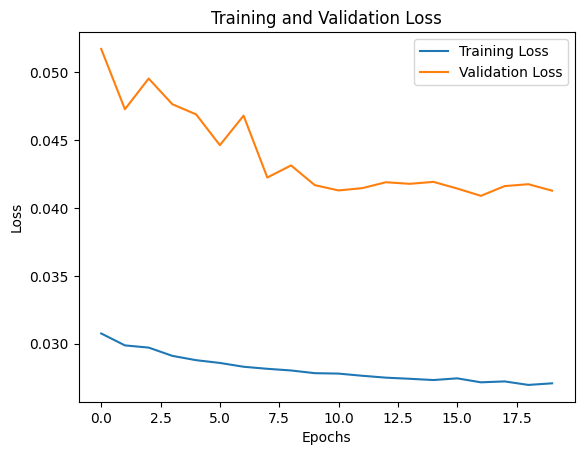

In [ ]:
history = model.fit(train_generator, epochs=20, validation_data=test_generator)
# Visualize training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# from tensorflow.keras.models import load_model

# # Replace with the actual path to your saved model
# model_path = '/content/drive/MyDrive/your_model_name.keras'

# # Load the model
# model = load_model(model_path)

116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


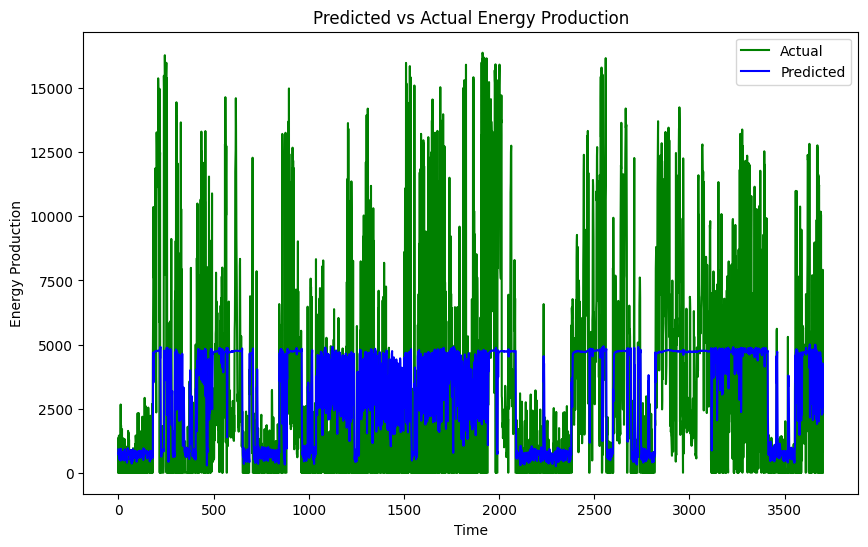

In [ ]:
# Assuming 'scaler1' was used to scale 'Production' during training
predictions = model.predict(test_generator)

# Rescale the predictions and actual values back to original scale
predicted_rescaled = scaler1.inverse_transform(predictions.reshape(-1, 1))
actual_rescaled = scaler1.inverse_transform(y_test[window_size:].reshape(-1, 1)) # Access the values of the DataFrame and then reshape
  # Use scaler1 for the actual values too

# Plotting the actual vs predicted energy production
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(actual_rescaled, color='green', label='Actual')
plt.plot(predicted_rescaled, color='blue', label='Predicted')
plt.title('Predicted vs Actual Energy Production')
plt.xlabel('Time')
plt.ylabel('Energy Production')
plt.legend()
plt.show()

In [ ]:


# Adjust actual values to account for the window size used in the generator
actual = y_test[window_size:]  # Convert y_test to values to avoid alignment issues

# Calculate metrics
mse = mean_squared_error(actual_rescaled, predicted_rescaled)
mae = mean_absolute_error(actual_rescaled, predicted_rescaled)
r2 = r2_score(actual_rescaled, predicted_rescaled)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")


Mean Squared Error (MSE): 12240420.738834105
Mean Absolute Error (MAE): 2559.2744339417923
R² Score: 0.22781318946326645


In [ ]:
# Specify the path where the model will be saved in Google Drive
model_save_path = '/content/drive/My Drive/your_model_name.keras'

# Save the model in HDF5 format (use .h5 extension)
model.save(model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to /content/drive/My Drive/your_model_name.keras
